# Evaluation of VEmotion for in-the-wild perceived emotion prediction

Importing of packages.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import mplleaflet
import json
import seaborn as sns
import datetime 
import sklearn

from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, LabelEncoder

from sklearn.model_selection import LeavePGroupsOut, StratifiedKFold, train_test_split, KFold, \
                                    ShuffleSplit,LeaveOneGroupOut, cross_val_score, LeaveOneGroupOut,\
                                    cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix, r2_score, plot_roc_curve, auc, classification_report,\
                            accuracy_score, plot_confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline

from sklearn.inspection import permutation_importance
import warnings


from lib.vehicle_trajectory import create_acceleration_series
warnings.filterwarnings('ignore')  

#### Import study data
In the following block, we import the participants study data of VEmotion, consent to use participants data is given for this research project. After importing the individual dataframes from the participants, the dataframes are merged and missing values are imputed and feature columns for the machine learning analysis are selected.

In [4]:
datadirs =[{'participant_id':1, 'DATADIR': 'VEmotion_data/participant1/', 
            'age': 21, 'before_emotion':'happiness', 'daytime': 'evening'},
           {'participant_id':2, 'DATADIR': 'VEmotion_data/participant2/',
           'age': 28, 'before_emotion':'happiness', 'daytime': 'night'},
           {'participant_id':3, 'DATADIR': 'VEmotion_data/participant3/',
           'age': 27, 'before_emotion':'happiness', 'daytime': 'evening'},
           {'participant_id':4, 'DATADIR': 'VEmotion_data/participant4/',
           'age': 21, 'before_emotion':'neutral', 'daytime': 'noon'},
          {'participant_id':5, 'DATADIR': 'VEmotion_data/participant5/', 
          'age': 24, 'before_emotion':'neutral', 'daytime': 'morning'},
          {'participant_id':6, 'DATADIR': 'VEmotion_data/participant6/',
          'age': 24, 'before_emotion':'neutral', 'daytime': 'noon'},
          {'participant_id':7, 'DATADIR': 'VEmotion_data/participant7/',
          'age': 35, 'before_emotion':'neutral', 'daytime': 'noon'},
          {'participant_id':8, 'DATADIR': 'VEmotion_data/participant8/',
          'age': 26, 'before_emotion':'happiness', 'daytime': 'morning'},
          {'participant_id':9, 'DATADIR': 'VEmotion_data/participant9/',
          'age': 24, 'before_emotion':'happiness', 'daytime': 'noon'},
           {'participant_id':10, 'DATADIR': 'VEmotion_data/participant10/', 
          'age': 31, 'before_emotion':'happiness', 'daytime': 'noon'},
           {'participant_id':11, 'DATADIR': 'VEmotion_data/participant11/', 
          'age': 35, 'before_emotion':'happiness', 'daytime': 'afternoon'},
          {'participant_id':12, 'DATADIR': 'VEmotion_data/participant12/',
          'age': 28, 'before_emotion':'neutral', 'daytime': 'noon'},
          ]

for i, elem in enumerate(datadirs):
    data = pd.read_csv(elem['DATADIR']+'export.csv', index_col = 0)
    print(f'i {i}, data_shape: {data.shape}, part: {elem}')
    data['participant_id'] = elem['participant_id']
    data['age'] = elem['age']
    data['before_emotion'] = elem['before_emotion']
    data['daytime'] = elem['daytime']
    
    
    #check how many different emotions were expressed by each individual participant
    le_expressed = preprocessing.LabelEncoder()
    s = pd.Series( le_expressed.fit_transform(data.expressed_emotion) )
    time_indices_change_emotion = s.diff()[s.diff() != 0].index.values

    print(f'participant: {i}, data-shape: {data.shape}')
    print(f'number of different emotions expressed: {time_indices_change_emotion.shape}')
    if 'road_type' in data.columns:
        print(f'number of different individual road types: {data.road_type.value_counts().shape}')
    
    if i ==0:
        data_gps = data
    else:
        data_gps = pd.concat([data_gps, data], ignore_index=True)
        
        

data_gps.rename(columns={"Speed_gps": "vehicle_speed", "Max_Emotion": "facial_expression",
                         "lanes": 'n_lanes'}, inplace = True)

#converting Timestamp column
data_gps.Timestamp = pd.to_datetime(data_gps.Timestamp)




acc = create_acceleration_series(data_gps)
#add acceleration to feature list
data_gps['vehicle_acceleration'] = acc

feature_columns = ['vehicle_speed','vehicle_acceleration',
                    'feeltemp_outside', 'windspeed', 'cloud_coverage', 
                  'trafficflow_reducedspeed', 'freeflow_speed', 'road_type','weather_term', 'facial_expression',
                   'max_speed', 'n_lanes', 'daytime', 'age', 'before_emotion'
                    ] 

trafficcontext = ['trafficflow_reducedspeed', 'freeflow_speed']
roadcontext = ['road_type', 'max_speed', 'n_lanes']
vehiclecontext = ['vehicle_speed', 'vehicle_acceleration']
weathercontext = ['weather_term','feeltemp_outside', 'windspeed', 'cloud_coverage']
facialcontext = ['facial_expression']
personalcontext = ['age', 'before_emotion']
timecontext = ['daytime']

allcontext = timecontext + personalcontext +facialcontext+weathercontext+vehiclecontext+roadcontext+trafficcontext
                
    
data_gps = data_gps[data_gps.expressed_emotion.isin(['neutral', 'happiness','angry', 'contempt','disgust', 'fear', 'sadness', 'surprise'])]
data_gps = data_gps.dropna(subset=['expressed_emotion'])
data_gps = data_gps.drop_duplicates()

#default lanes == 0
data_gps.n_lanes = data_gps.n_lanes.fillna(1.0)
#default road_type == 'unknown'
data_gps.road_type = data_gps.road_type.fillna('unknown')
#default max_speed = 0
data_gps.max_speed = data_gps.max_speed.fillna(0)
#default facial expression == 'unknown'
data_gps.facial_expression = data_gps.facial_expression.fillna('unknown')
facial_expression_columns = ['anger','contempt','disgust', 'fear', 'happiness','neutral','sadness','surprise']
for col_name in facial_expression_columns:
    data_gps[col_name] = data_gps[col_name].fillna('unknown')


print(data_gps.facial_expression.unique())
data_plot = data_gps.copy()

data_gps.reset_index(drop = True, inplace = True)


le = preprocessing.LabelEncoder()
y_labelenc = le.fit_transform(data_gps.expressed_emotion)
y_label = data_gps.expressed_emotion
le_road_type = preprocessing.LabelEncoder()
le_weather_term = preprocessing.LabelEncoder()
le_facial = preprocessing.LabelEncoder()
le_daytime = preprocessing.LabelEncoder()
le_before_emotion = preprocessing.LabelEncoder()

data_gps.road_type = le_road_type.fit_transform(data_gps.road_type)

data_gps.weather_term = le_weather_term.fit_transform(data_gps.weather_term)

data_gps.facial_expression = le_facial.fit_transform(data_gps.facial_expression.astype(str))

data_gps.daytime = le_daytime.fit_transform(data_gps.daytime.astype(str))

data_gps.before_emotion = le_before_emotion.fit_transform(data_gps.before_emotion.astype(str))

#dump label encoder to file
np.save('../../models/le_road_type.npy', le_road_type.classes_)
np.save('../../models/le_weather_term.npy', le_weather_term.classes_)
np.save('../../models/le_facial.npy', le_facial.classes_)
np.save('../../models/le_daytime.npy', le_daytime.classes_)
np.save('../../models/le_before_emotion.npy', le_before_emotion.classes_)

for col_name in facial_expression_columns:
    data_gps[col_name] = preprocessing.LabelEncoder().fit_transform(data_gps[col_name].astype(str))
    
X = data_gps.loc[:, feature_columns]
X_scaled = preprocessing.StandardScaler().fit_transform(X)


#assign X and y variables
y = np.asarray(y_label)
groups = data_gps.participant_id

X = X.dropna()
y = y[X.index]

data_gps = data_gps.iloc[X.index, :]
groups = groups[X.index]

data_gps.shape

i 0, data_shape: (632, 27), part: {'participant_id': 1, 'DATADIR': 'VEmotion_data/participant1/', 'age': 21, 'before_emotion': 'happiness', 'daytime': 'evening'}
participant: 0, data-shape: (632, 31)
number of different emotions expressed: (6,)
number of different individual road types: (7,)
i 1, data_shape: (584, 27), part: {'participant_id': 2, 'DATADIR': 'VEmotion_data/participant2/', 'age': 28, 'before_emotion': 'happiness', 'daytime': 'night'}
participant: 1, data-shape: (584, 31)
number of different emotions expressed: (6,)
number of different individual road types: (13,)
i 2, data_shape: (372, 27), part: {'participant_id': 3, 'DATADIR': 'VEmotion_data/participant3/', 'age': 27, 'before_emotion': 'happiness', 'daytime': 'evening'}
participant: 2, data-shape: (372, 31)
number of different emotions expressed: (1,)
number of different individual road types: (10,)
i 3, data_shape: (656, 27), part: {'participant_id': 4, 'DATADIR': 'VEmotion_data/participant4/', 'age': 21, 'before_emot

(8985, 32)

mean time between emotions across users: 0 days 00:02:50.593148865
std: 0 days 00:03:59.999979258


## Data Description
#### Analysis of time between expressed emotion

In [10]:
#check for time of different emotions (calculate participants segments of rides)
data_gps['delta'] = (data_gps['Timestamp']-data_gps['Timestamp'].shift()).fillna(pd.Timedelta('0 seconds'))
le_expressed = preprocessing.LabelEncoder()
data_gps['expressed_emotion_le'] = le_expressed.fit_transform(data_gps.expressed_emotion)
s = data_gps['expressed_emotion_le'] 
time_indices_change_emotion = s.diff()[s.diff() != 0].index.values
list_time_between = []
for i in range(len(time_indices_change_emotion)-2):
    time_between = data_gps.loc[time_indices_change_emotion[i+1], 'Timestamp'] - data_gps.loc[time_indices_change_emotion[i], 'Timestamp'] 
    if time_between > datetime.timedelta(hours=2) or time_between < datetime.timedelta(0):
        continue
    else:
        list_time_between.append(time_between)
        
mean_timedelta = np.asarray(list_time_between).mean()
time_between = pd.DataFrame({'diff':  list_time_between})

time_between['std'] = time_between['diff'].values.astype(np.int64)
mean = time_between.mean()
time_between['std'] = pd.to_timedelta(time_between['std'])
std = time_between.loc[1, 'std']

print(f'mean time between emotions across users: {mean_timedelta}')
print(f'std: {  std}')

for participant in data_gps.participant_id.unique():
    print( data_gps.loc[data_gps.participant_id == participant, 'Timestamp'].diff().mean() )

mean time between emotions across users: 0 days 00:02:50.593148865
std: 0 days 00:03:59.999979258
0 days 00:00:01.003215411
0 days 00:00:01.212406612
0 days 00:00:01.288459599
0 days 00:00:01.031580253
0 days 00:00:01.317926019
0 days 00:00:01.104592745
0 days 00:00:01.254804181
0 days 00:00:01.032636380
0 days 00:00:01.004299977
0 days 00:00:01.015571
0 days 00:00:01.221590957
0 days 00:00:01.086350173


#### perceived emotional classes

neutral      5780
happiness    2838
surprise      177
angry         130
disgust        60
Name: expressed_emotion, dtype: int64
neutral      0.643294
happiness    0.315860
surprise     0.019699
angry        0.014469
disgust      0.006678
Name: expressed_emotion, dtype: float64


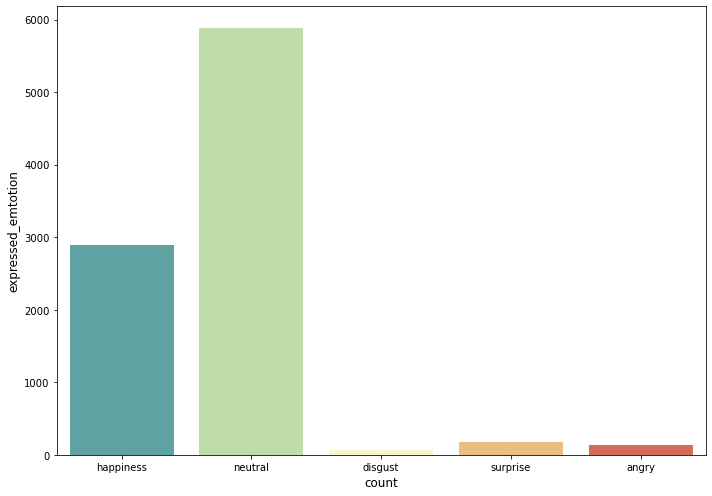

In [11]:
#plot emotions
fig_data, ax = plt.subplots(1,1,figsize = (10,7))
#sns.set_theme(style="rocket")
pl = sns.light_palette("seagreen", as_cmap=True)
sns.countplot(x="expressed_emotion", data=data_plot, ax = ax, palette = 'Spectral_r')
ax.set_xlabel('count', fontsize = 12)
ax.set_ylabel('expressed_emtotion', fontsize = 12)
plt.tight_layout()

fig_data.savefig('paper_plots/expressed_emotion_hist.pdf', dpi = 400)
print(data_gps.expressed_emotion.value_counts())
print(data_gps.expressed_emotion.value_counts()/data_gps.shape[0])

## Extracted Emotions from Facial Expressions
We analyze the facial expressions alone and compare them against the actual perceived emotions in a confusion matrix. 

0.5562110783349722
UAR facial expressions (only on true labels): 0.17853250367832468, SD: 0.36929502311661433
UAR_facial_all: 0.11158281479895293, SD: 0.0


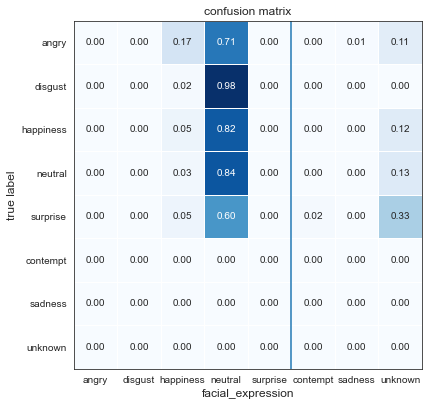

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import cm

cm = confusion_matrix(data_plot.expressed_emotion, data_plot.facial_expression,  normalize='true')


#names of the expressed and facial emotions have to be defined for the xticks and yticks
target_names = np.unique([data_plot.expressed_emotion, data_plot.facial_expression])



#ordered confusion matrix
fig, (ax1) = plt.subplots(1,1, figsize=(6,6))
reorder_idx = [0, 2, 3, 4, 6,1,5,7]
cm_reordered = cm[reorder_idx][:,reorder_idx]
target_names_reordered = target_names[reorder_idx]
#plotting with seaborn
sns.set_style("white")
sns.heatmap(cm_reordered, annot=True, fmt='.2f', xticklabels=target_names_reordered, yticklabels=target_names_reordered, 
           cmap=plt.get_cmap('Blues'), square = True, linewidths=.5, cbar=False, ax = ax1)
ax1.set_xlabel('facial_expression', fontsize = 12)
ax1.set_ylabel('true label', fontsize = 12)


#ax1.set_ylabel('expressed_emotion')
accuracy = accuracy_score(data_plot.expressed_emotion, data_plot.facial_expression)
print(accuracy)
ax1.set_title('confusion matrix')

for _, spine in ax1.spines.items():
    spine.set_visible(True)
ax1.vlines([5], *ax1.get_xlim())
plt.tight_layout()

plt.savefig('paper_plots/confusion_matrix_facialexpressions_only.pdf', dpi = 400)

#the results of facial expressions are saved for Table 2 in paper
clf_report = classification_report(data_plot.expressed_emotion, data_plot.facial_expression, digits=3, output_dict = True, zero_division = 0)
clf_report_facial = pd.DataFrame(clf_report).iloc[:-1, :].T


clf_report_facial['context'] = 'facial only'
clf_report_facial['Evaluation'] = 'simple comparison'

clf_report_overall = clf_report_facial
UR_facial = clf_report_facial.loc[['angry','disgust', 'happiness', 'neutral', 'surprise'],'recall']
print(f'UAR facial expressions (only on true labels): {UR_facial.mean() }, SD: {UR_facial.std()}')
UR_facial_all = clf_report_facial.loc[['angry','disgust', 'happiness', 'neutral', 'surprise', 'unknown', 'sadness', 'contempt'],'recall'].mean()
print(f'UAR_facial_all: {UR_facial_all.mean() }, SD: {UR_facial_all.std()}')

# Leave-one-participant-out cross-validation
We perform a leave-one-participant-out cross validation with different permutations of available features and report the classifiers performance of predicting the perceived emotions. 

(8985,)
(8985, 15)

i: 0, context: facialcontext
cross_validate: 
accuracy: 0.09791375083102909 (SD: 0.21445117381846354)
precision: 0.08061177462275988 (SD: 0.14923895775053206)
recall: 0.09791375083102909 (SD: 0.21445117381846354)
F1: 0.07815482651346208 (SD: 0.17307192259210244)
list: 
mean accuracy: 0.5876455994214643, sd accuracy: 0.23257071703020502
mean precision: 0.3423336113447087, sd precision: 0.11249274336472333
mean recall: 0.30134077917540397, sd recall: 0.12563506625126614
mean f1: 0.2768791827263449, sd f1: 0.12070222736481906
mean unweighted recall (UAR): 0.30134077917540397, sd UAR: 0.12563506625126614
neutral baseline recall: 0.2
neutral acc 0.6432943795214245
neutral precision: 0.41382765872385463
neutral recall: 0.6432943795214245 
neutral f1: 0.503656148138684

i: 1, context: all contexts 
 without facialcontext
cross_validate: 
accuracy: 0.6371975790101304 (SD: 0.17692482338416965)
precision: 0.5632758445359087 (SD: 0.235096684755866)
recall: 0.6371975790101304 (

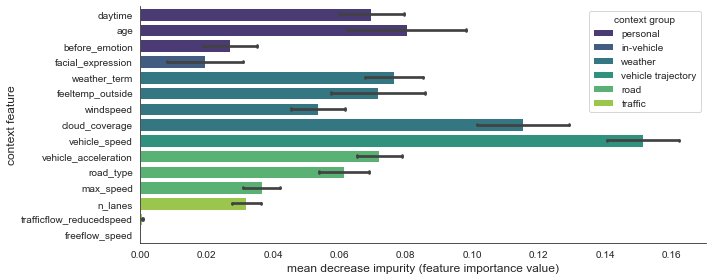

In [16]:
contextlist = [facialcontext,
              weathercontext + trafficcontext+ vehiclecontext+roadcontext+personalcontext+timecontext,
               allcontext
              ]

contexttext_list = ['facialcontext','all contexts \n without facialcontext', 'all contexts']

print(y.shape)
print(X.shape)
cm_context = []
for i, elem in enumerate(contextlist):
    print(f'\ni: {i}, context: {contexttext_list[i]}')
    context = contextlist[i] 
    context_text = contexttext_list[i]

    cv_loo = LeaveOneGroupOut().split(X, y, groups)

    y = np.asarray(y_label)
    groups = data_gps.participant_id
    
    
    X = X.dropna()
    y = y[X.index]
    groups = groups[X.index]


    n_splits = 10

    logo = LeaveOneGroupOut()
    logo.get_n_splits(X, y, groups)

    X_context = X.loc[:, context]
    n_splits = 10


    cm_list = []
    feature_imp = []
    permutation_importances = []
    acc_list = []
    prec_list = []
    rec_list = []
    f1_list = []
    ur_list = [] #unweighted recall
    j = 0
    clf = RandomForestClassifier(n_estimators = 50, max_features= 'log2', class_weight = 'balanced', random_state = 0)
    result_cv =  cross_validate(clf, X_context ,y, cv=logo.split(X_context,y,groups), return_estimator = True, scoring = ['accuracy','precision_weighted', 'recall_weighted', 'f1_weighted'] )
    #if index_part == 1:
    acc_list_, prec_list_, rec_list_, f1_list_ = result_cv['test_accuracy'], result_cv['test_precision_weighted'],\
                                                        result_cv['test_recall_weighted'], result_cv['test_f1_weighted']
    print('cross_validate: ')
    print(f'accuracy: {acc_list_.mean() } (SD: {acc_list_.std() })')
    print(f'precision: {prec_list_.mean() } (SD: {prec_list_.std() })')
    print(f'recall: {rec_list_.mean()} (SD: {rec_list_.std() })')
    print(f'F1: {f1_list_.mean()} (SD: {f1_list_.std() })')

    for train_index, test_index in logo.split(X_context,y,groups):
        X_train, X_test = X_context.iloc[train_index], X_context.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if context_text == 'facialcontext':
            y_pred = le_facial.inverse_transform(X_test[context])
        else:
            clf = RandomForestClassifier(n_estimators = 50, max_features= 'log2', class_weight = 'balanced', random_state = 0)
            clf.fit(X_train, y_train)
            #print("TRAIN:", train_index, "TEST:", test_index)
            feature_imp.append(clf.feature_importances_)
            

            y_pred = clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec_, rec_, f1_, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division = 0)
        
        
        _, ur, _, _ = prec_, rec_, f1_, _ = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division = 0)
        
        acc_list.append(acc)
        prec_list.append(prec_)
        rec_list.append(rec_)
        f1_list.append(f1_)
        
        ur_list.append(ur)
        #print(f'testset accuracy: {acc}')
        cm = confusion_matrix(y_test, y_pred)
        cm_list.append(cm)
        if j ==0:
            y_global_test = y_test
            y_global_pred = y_pred
        else:
            y_global_test = np.append(y_global_test, y_test, axis = 0)
            y_global_pred = np.append(y_global_pred, y_pred, axis = 0)

        j+= 1
    
    
    cm = confusion_matrix(y_global_test, y_global_pred, normalize = 'true')
    cm_context.append(cm)
    acc_list = np.asarray(acc_list)
    prec_list = np.asarray(prec_list)
    rec_list = np.asarray(rec_list)
    f1_list = np.asarray(f1_list)
    ur_list = np.asarray(ur_list)
    print('list: ')
    print(f'mean accuracy: {acc_list.mean() }, sd accuracy: {acc_list.std()}')
    print(f'mean precision: {prec_list.mean() }, sd precision: {prec_list.std()}')
    print(f'mean recall: {rec_list.mean() }, sd recall: {rec_list.std()}')
    print(f'mean f1: {f1_list.mean() }, sd f1: {f1_list.std()}')     
    
    
    print(f'mean unweighted recall (UAR): {ur_list.mean() }, sd UAR: {ur_list.std()}')     
    from sklearn.metrics import recall_score
    #UAR recall only predicting 'neutral' emotions
    y_pred_only_neutral = np.repeat('neutral', y_global_test.shape[0])
    rec_neutral_baseline = recall_score(y_global_test, y_pred_only_neutral, average = 'macro')
    print(f'neutral baseline recall: {rec_neutral_baseline }')

    
    prec_, rec_, f1_, _ = precision_recall_fscore_support(y_global_test, y_pred_only_neutral, average='weighted', zero_division = 0)
    acc_neutral = sklearn.metrics.accuracy_score(y_global_test, y_pred_only_neutral, normalize=True)
    print(f'neutral acc {acc_neutral}')
    print(f'neutral precision: {prec_ }')
    print(f'neutral recall: {rec_ } ')
    print(f'neutral f1: {f1_ }')   


    clf_report = pd.DataFrame(classification_report(y_global_test, y_global_pred, digits=3, output_dict = True, zero_division = 0)).iloc[:-1, :].T
    clf_report_copy = clf_report.copy()
    clf_report_copy['context'] = context_text
    clf_report_copy['Evaluation'] = 'leave one participant out'

    clf_report_overall = pd.concat([clf_report_overall, clf_report_copy])
    

context_group = ['personal', 'personal', 'personal', 'in-vehicle', 'weather', 'weather', 'weather', 'weather','vehicle trajectory', 'road', 'road', 'road', 'traffic', 'traffic']
context_mapping = dict(zip(X_context.columns.values, context_group))
feature_imp = np.asarray(feature_imp)
mean_feature_imp_ = np.mean(feature_imp, axis = 0)
std_feature_imp_ = np.std(feature_imp, axis = 0)

df_feature_imp_lopo = pd.DataFrame(data = feature_imp, columns = X_context.columns.values).melt()
df_feature_imp_lopo["context group"] = df_feature_imp_lopo["variable"].map(context_mapping)
sns.set_context(rc = {'patch.linewidth': 1.0})
sns.color_palette("Blues", 8)
fig, (ax1) = plt.subplots(1,1, figsize=(10,4))
sns.barplot(data = df_feature_imp_lopo, x= 'value', y = 'variable', hue = 'context group', orient = 'h', capsize=.1,
            dodge = False,ci = 'sd', ax = ax1, palette="viridis")#
ax1.set_ylabel('context feature', fontsize = 12)
ax1.set_xlabel('mean decrease impurity (feature importance value)', fontsize = 12)
plt.tight_layout()
sns.despine()
plt.savefig('paper_plots/lopo_feature_importances_allcontext2.pdf', dpi = 400)


#get mean and standard deviations of feature importances
print(f'mean feature importances: {df_feature_imp_lopo.groupby('variable').mean()}') #std

#### Analysis of the feature importances conditioned on the emotional class

,feature,variable,value
0,vehicle_speed,happiness,0.934642
1,vehicle_acceleration,happiness,0.000405
2,feeltemp_outside,happiness,0.076583
3,windspeed,happiness,0.262458
4,cloud_coverage,happiness,3.158897
...,...,...,...
70,max_speed,disgust,1.538683
71,n_lanes,disgust,0.058876
72,daytime,disgust,0.042094
73,age,disgust,0.015311


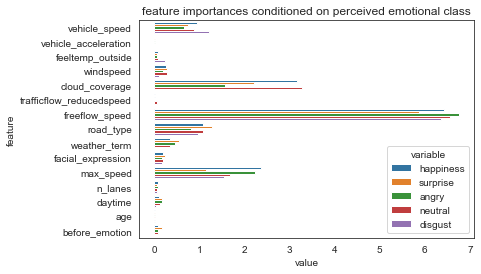

In [26]:
# To get the importance according to each class -> looking at all observations feature importances subject by emotional class
def class_feature_importance(X, Y, feature_importances):
    N, M = X.shape

    out = {}
    for c in set(Y):
        out[c] = dict(
            zip(range(N), X.loc[Y==c, :].mean()*feature_importances)
        )

    return out
importances = feature_imp[0]
result = class_feature_importance(X, y, importances)
#print (json.dumps(result,indent=4))

# Plot the feature importances of the forest
df_result = pd.DataFrame(result)
df_result.index = X.columns
df_result['feature'] = df_result.index
df_result.reset_index(drop = True, inplace = True)
df_result = pd.melt(df_result, id_vars=['feature'], value_vars=['happiness','surprise','angry','neutral','disgust'])
sns.barplot(data = df_result, y= 'feature', x= 'value', hue = 'variable')
plt.title('feature importances conditioned on perceived emotional class')
#df_result.loc[df_result.variable == 'disgust'].sort_values('value') -> looking e.g. at importances of disgust emotions
df_result

#### Permutation importance calculation
The feature importance computed before is based on impurity measurements in the training procedure of the random forest. Permutation importance however is less prone to class cardinality and measures the decrease in 'f1_weighted' if one feature is randomly permuted (no information content). The computation might take a while.

In [35]:
#include selection of features
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import RFECV

clf = RandomForestClassifier(n_estimators = 50, max_features= 'log2', class_weight = 'balanced', random_state = 0)
cv = LeaveOneGroupOut().split(X, y, groups)


mean_imp = []
for train_index, test_index in cv:
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    ## perform permutation importance
    results = permutation_importance(clf, X_train, y_train, scoring='f1_weighted')
    # get importance
    importance = results.importances_mean
    mean_imp.append(importance)
    # summarize feature importance
    #for i,v in enumerate(importance):
    #    print(f'Feature: {X.columns[i]}, Score: {v}')

mean_imp_permutation = np.asarray(mean_imp)

#plotting permutation importances
feature_imp_df = pd.DataFrame(data = mean_imp_permutation, columns = X.columns)
feature_imp_df = feature_imp_df.unstack().reset_index() 
feature_imp_df.columns = ['feature', 'fold', 'value']
fig, ax = plt.subplots(1,1,figsize = (10,5))
sns.boxplot(y = 'feature', x = 'value', data = feature_imp_df, ax = ax)
ax.set_xlabel(r'permutation importance (decrease in $F_1$ when feature is excluded)')
ax.set_title('Permutation importance in Leave-One-Participant-Out CV')
plt.tight_layout()
fig.savefig('paper_plots/permutation_importance_lopo.png')

## Recursive Feature Elimination
compute number of features and their corresponding highest achievable F1 score

>2 0.516 (0.121)
>3 0.618 (0.195)
>4 0.589 (0.205)
>5 0.616 (0.210)
>6 0.593 (0.227)
>7 0.595 (0.217)
>8 0.584 (0.225)
>9 0.597 (0.212)
>10 0.586 (0.229)
>11 0.580 (0.227)
>12 0.582 (0.220)
>13 0.560 (0.234)
>14 0.552 (0.229)
mean score: 0.5893915352334554
features considered: Index(['vehicle_speed', 'cloud_coverage', 'freeflow_speed', 'weather_term'], dtype='object')


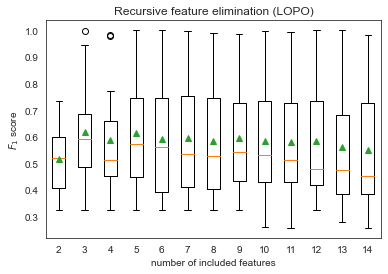

In [37]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

 
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(2, 15):
        estimator = RandomForestClassifier(n_estimators = 50, max_features= 'log2', class_weight = 'balanced', random_state = 0)
        rfe = RFE(estimator=estimator, n_features_to_select=i)
        
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',estimator)])
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    cv = LeaveOneGroupOut().split(X, y, groups)
    scores = cross_val_score(model, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1, error_score='raise')
    return scores

models = get_models()

results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# evaluate the models and store results
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.xlabel('number of included features')
plt.ylabel(r'$F_1$ score')
plt.title('Recursive feature elimination (LOPO)')
plt.savefig('paper_plots/RFE_F1_scoring.png')

#which features are these 4 from RFE
best_n_features = 4
#get ranking of RFE with 4 features
estimator = RandomForestClassifier(n_estimators = 50, max_features= 'log2', class_weight = 'balanced', random_state = 0)
rfe = RFE(estimator=estimator, n_features_to_select=best_n_features)
pipe = Pipeline(steps=[('s',rfe),('m',estimator)])
cv = LeaveOneGroupOut().split(X, y, groups)
n_scores = cross_val_score(pipe, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
#scores = cross_val_score(model, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1, error_score='raise')
print(f'mean score: {np.mean(n_scores)}')
pipe.fit(X, y)
print(f'features considered: {X.columns[rfe.support_]}')

## Participant-dependent 10-Fold cross-validation
Here, we analyze a model that is only trained on one participants data. The evaluation is based on unshuffled 10-fold cross validation on the basis of participants driving data and performance of the learned classifier is aggregated over all participants. 

In [41]:
contextlist = [facialcontext,weathercontext + trafficcontext+ vehiclecontext+roadcontext+personalcontext+timecontext, 
              allcontext]
contexttext_list = ['facialcontext','all contexts \n without facialcontext', 'all contexts']
X = data_gps.loc[:, feature_columns]
#X_scaled = preprocessing.StandardScaler().fit_transform(X)

X = X.dropna()

data_gps = data_gps.reset_index(drop = True)
for i, elem in enumerate(contextlist):

    context = contextlist[i] 
    context_text = contexttext_list[i]
    print(f'i: {i}, context: {context_text}')
    cv_loo = LeaveOneGroupOut().split(X, y, groups)


    y = np.asarray(y_label)
    groups = data_gps.participant_id
    
    
    X = X.dropna()
    y = y[X.index]
    groups = groups[X.index]


        
    kfold = KFold(n_splits = 10, shuffle = False)
    X_context = X.loc[:, context]
    # allocate statistics over all participants
    index_part = 0
    for participant in groups.unique():
        index_part += 1
    
        X_context_part = X_context.loc[data_gps.participant_id == participant,:]
        
        #if X_context_part.shape[1]>1:
        #    y_part = y[X_context_part.index]
        #else:    
        y_part = y[X_context_part.index]    
        #print(f'y_part.shape: {y_part.shape}')
        
        
        clf = RandomForestClassifier(n_estimators = 50, max_features= 'log2', class_weight = 'balanced', random_state = 0)
        if context_text == 'facialcontext':
            y_pred_fold = le_facial.inverse_transform(X_context_part.facial_expression)
            target_names = np.unique([data_plot.expressed_emotion, data_plot.facial_expression])
        else:
            y_pred_part = cross_val_predict(clf, X_context_part, y_part, cv=kfold)
            target_names = np.unique(y)
            
        
        result_cv =  cross_validate(clf, X_context_part, y_part, cv=kfold, return_estimator = True, scoring = ['accuracy','precision_weighted', 'recall_weighted', 'f1_weighted'])
        if index_part == 1:
            acc_list, prec_list, rec_list, f1_list = result_cv['test_accuracy'], result_cv['test_precision_weighted'],\
                                                            result_cv['test_recall_weighted'], result_cv['test_f1_weighted']
        else:
            acc_list =  np.vstack(( acc_list, result_cv['test_accuracy']))
            prec_list =   np.vstack( (prec_list, result_cv['test_precision_weighted']) )
            rec_list =  np.vstack((rec_list,result_cv['test_recall_weighted']))
            f1_list =  np.vstack((f1_list, result_cv['test_f1_weighted']))
        
        for u in range(len(result_cv['estimator'])):
            if u == 0:
                feature_importances_part = result_cv['estimator'][u].feature_importances_
            else:
                feature_importances_part = result_cv['estimator'][u].feature_importances_ + feature_importances_part
        

        

            

    cm_total = confusion_matrix(y_global_test, y_global_pred)
    acc = accuracy_score(y_global_test, y_global_pred)
    
    print(f'mean accuracy: {acc}')
    
    print(f'accuracy: {acc_list.mean(axis = 1).mean() } (SD: {acc_list.mean(axis = 1).std() })')
    print(f'precision: {prec_list.mean(axis = 1).mean() } (SD: {prec_list.mean(axis = 1).std() })')
    print(f'recall: {rec_list.mean(axis = 1).mean()} (SD: {rec_list.mean(axis = 1).std() })')
    print(f'F1: {f1_list.mean(axis = 1).mean()} (SD: {f1_list.mean(axis = 1).std() })')



    clf_report = pd.DataFrame(classification_report(y_global_test, y_global_pred, digits=3, output_dict = True, zero_division = 0)).iloc[:-1, :].T
    clf_report_copy = clf_report.copy()
    clf_report_copy['context'] = context_text
    clf_report_copy['Evaluation'] = 'participant kfold'

    clf_report_overall = pd.concat([clf_report_overall, clf_report_copy])


i: 0, context: facialcontext
mean accuracy: 0.6003338898163606
accuracy: 0.4581736071046176 (SD: 0.30903090871276717)
precision: 0.5595611120928664 (SD: 0.33328641600329767)
recall: 0.4581736071046176 (SD: 0.30903090871276717)
F1: 0.45590222748919057 (SD: 0.32110169977620934)
i: 1, context: all contexts 
 without facialcontext
mean accuracy: 0.6003338898163606
accuracy: 0.7067266290909594 (SD: 0.17129276747285466)
precision: 0.8859358476850691 (SD: 0.09198927741164675)
recall: 0.7067266290909594 (SD: 0.17129276747285466)
F1: 0.7281794476925615 (SD: 0.1576527565990487)
i: 2, context: all contexts
mean accuracy: 0.6003338898163606
accuracy: 0.7043306895008116 (SD: 0.1670531124001716)
precision: 0.8851015408998562 (SD: 0.08404728481940396)
recall: 0.7043306895008116 (SD: 0.1670531124001716)
F1: 0.7282902313594701 (SD: 0.15090940709117076)


## Global 10-Fold cross-validation on unseen rides
Below, we calculate the global model (learning on all participants data) but leave one segment (size: 1/10) for testing for each participant. A further explanation of how we construct the trainings- and test set for the global (participant-independent) modeling is described in the paper.

i: 0, context: facialcontext 
list: 
mean accuracy: 0.555586(0.0606)
mean precision: 1.0(0.0834)
mean recall: 0.5556(0.0606)
mean f1: 0.5075(0.0773)
i: 1, context: allcontext 
list: 
mean accuracy: 0.719991(0.0787)
mean precision: 1.0(0.081)
mean recall: 0.72(0.0787)
mean f1: 0.7164(0.0791)
i: 2, context: all without facial context 
list: 
mean accuracy: 0.717035(0.074)
mean precision: 1.0(0.0728)
mean recall: 0.717(0.074)
mean f1: 0.713(0.0713)


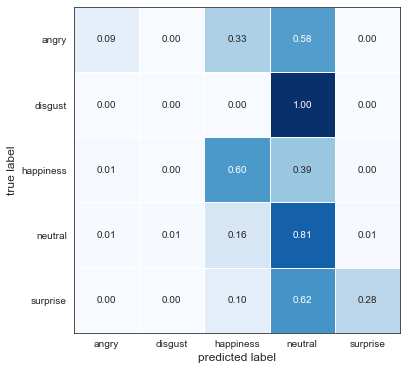

In [42]:
n_splits = 10
y = np.asarray(y_label)
groups = data_gps.participant_id

contextlist = [facialcontext,
               allcontext,
              weathercontext + trafficcontext+ vehiclecontext+roadcontext+personalcontext+timecontext               
              ]
contexttext_list = ['facialcontext',
               'allcontext',
              'all without facial context'              
              ]

for i, elem in enumerate(contextlist):
    context = contextlist[i] 
    context_text = contexttext_list[i]
    print(f'i: {i}, context: {context_text} ')   
    X_context = X.loc[:, context]


    list_X_part = []
    list_y_part = []
    list_kfold_part = []

    #for every participant get splits
    for part_ in groups.unique():

        #get only participants data
        X_context_part = X_context.loc[data_gps.participant_id == part_,:]
        y_part = y[X_context_part.index]

        #save participants data to list
        list_X_part.append(X_context_part)
        list_y_part.append(y_part)

        #learn Kfold iterator on data
        kfold_iter_part = KFold(n_splits = n_splits, shuffle = False)
        kfold_iter_part = kfold_iter_part.split(X_context_part)
        list_kfold_part.append(kfold_iter_part)

    acc_list = []
    prec_list = []
    rec_list = []
    f1_list = []
    cm_list = []
    #go through all folds
    for fold in range(n_splits):
        #get all participants training data and stack them
        for p_no, part_ in enumerate(groups.unique()):
            X_context_part = list_X_part[p_no]
            y_part = list_y_part[p_no]

            #get fold split
            kfold_part_iter = list_kfold_part[p_no]
            train_part_idx, test_part_idx = next(kfold_part_iter)
            if p_no == 0:
                X_train_fold, X_test_fold = X_context_part.iloc[train_part_idx, :], X_context_part.iloc[test_part_idx, :]
                y_train_fold, y_test_fold = y_part[train_part_idx], y_part[test_part_idx]
            else:
                X_train_fold = pd.concat([X_train_fold, X_context_part.iloc[train_part_idx, :]])
                X_test_fold = pd.concat([X_test_fold, X_context_part.iloc[test_part_idx, :]])
                y_train_fold = np.append(y_train_fold, y_part[train_part_idx])
                y_test_fold = np.append(y_test_fold, y_part[test_part_idx])

        clf = RandomForestClassifier(n_estimators = 50, max_features= 'log2', class_weight = 'balanced', random_state = 0)
        clf.fit(X_train_fold, y_train_fold)
        if context_text == 'facialcontext':
            y_pred_fold = le_facial.inverse_transform(X_test_fold.facial_expression)
            target_names = np.unique([data_plot.expressed_emotion, data_plot.facial_expression])
        else:
            y_pred_fold = clf.predict(X_test_fold)
            target_names = np.unique(y)
        
        if fold == 0:
            y_pred_ = y_pred_fold
            y_test_ = y_test_fold
        else:
            y_test_ = np.append(y_test_, y_test_fold, axis = 0)
            y_pred_ = np.append(y_pred_, y_pred_fold, axis = 0)
            

        acc_ = accuracy_score(y_test_fold, y_pred_fold)
        prec_, rec_, f1_, _ = precision_recall_fscore_support(y_test_fold, y_pred_fold, average='weighted')

        acc_list.append(acc_)
        prec_list.append(prec_)
        rec_list.append(rec_)
        f1_list.append(f1_)
        
        
    acc_list = np.asarray(acc_list).reshape(-1,1)
    prec_list = np.asarray(prec_list).reshape(-1,1)
    rec_list = np.asarray(rec_list).reshape(-1,1)
    f1_list = np.asarray(f1_list).reshape(-1,1)
    print('list: ')
    print(f'mean accuracy: {np.round(acc_list.mean(),6) }({np.round(acc_list.std(), 4)})')
    print(f'mean precision: {np.round(prec_list.mean()) }({np.round(prec_list.std(),4)})')
    print(f'mean recall: {np.round(rec_list.mean() ,4)}({np.round(rec_list.std(),4)})')
    print(f'mean f1: {np.round(f1_list.mean(),4) }({np.round(f1_list.std(),4)})')
    rec_neutral_baseline = recall_score(y_global_test, y_pred_only_neutral, average = 'macro')
    
    #print(f'UAR: {}')
    
    #calculate confusion matrix
    cm = confusion_matrix(y_test_, y_pred_, normalize = 'true')
    
    
    #classification report 
    clf_report = pd.DataFrame(classification_report(y_test_, y_pred_, digits=3, output_dict = True)).iloc[:-1, :].T
    
    clf_report_copy = clf_report.copy()
    clf_report_copy['context'] = context_text
    clf_report_copy['Evaluation'] = 'global kfold participant split'

    clf_report_overall = pd.concat([clf_report_overall, clf_report_copy])




fig, (ax1) = plt.subplots(1,1, figsize=(6,6))

sns.set_style("white")
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, 
           cmap=plt.get_cmap('Blues'), square = True, linewidths=.5,cbar = False, ax = ax1)
ax1.set_xlabel('predicted label', fontsize = 12)
ax1.set_ylabel('true label', fontsize = 12)
#plt.xticks(rotation=90)
plt.yticks(rotation=0)
for _, spine in ax1.spines.items():
    spine.set_visible(True)



plt.savefig('paper_plots/global_kfold_unshuffled2'+context_text+'.pdf', dpi = 400)
#compute UAR
UR_kfold = clf_report.loc[['angry','disgust', 'happiness', 'neutral', 'surprise'],'recall'].mean()
print(f'UAR_facial_all: {UR_kfold.mean() }, SD: {UR_kfold.std()}')

### Export global classifier onto disk for inference time 

In [52]:
X_context = data_gps.loc[:, weathercontext + trafficcontext+ vehiclecontext+roadcontext+personalcontext+timecontext ]
y = np.asarray(y_label)
X.shape

(8985, 15)

In [53]:
X_context = X.loc[:, weathercontext + trafficcontext+ vehiclecontext+roadcontext+personalcontext+timecontext ]
y = np.asarray(y_label[X_context.index])
clf = RandomForestClassifier(n_estimators = 50, max_features= 'log2', class_weight = 'balanced', random_state = 0)
clf.fit(X_context, y)

import joblib
# now you can save it to a file
joblib.dump(clf, 'models/RandomForest.pkl') 

# and later it can be load using the following commands
#clf = joblib.load( '../../models/RandomForest.pkl')
#output = clf.predict( [ X_context.iloc[0,:].values ])
#print(output)

['models/RandomForest.pkl']

## Learning participant wise model (train using x min of data from participant) 
In the following analysis, we look at the prediction performance if we have data from the first x minutes of the ride. This may take a while to compute.

n_splits 12
finished


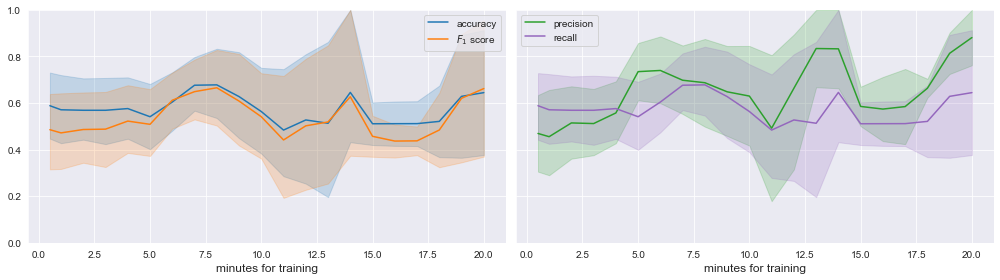

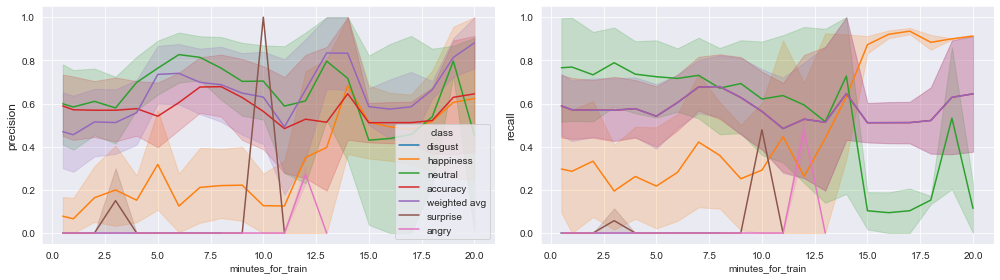

In [59]:
import sklearn.neighbors._base
import sys
#import mlrose
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
import six

sys.modules['sklearn.externals.six'] = six

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
y = np.asarray(y_label)
groups = data_gps.participant_id

X = X.dropna()
y = y[X.index]
groups = groups[X.index]

logo = LeaveOneGroupOut()
print(f'n_splits {logo.get_n_splits(X, y, groups)}')

i = 0

seconds_for_train = [30,60,120,180,240,300,360,420,480,540,600,660,720,780,840,900,960,1020,1080,1140,1200]
clf_reports = []
acc_list = []

for i in range(len(seconds_for_train)):
    first_seconds_for_train = seconds_for_train[i]
    for train_index, test_index in logo.split(X,y,groups):

        clf = RandomForestClassifier(n_estimators = 50, max_features= 'log2', class_weight = 'balanced', random_state = 0)
        X_train_other, X_test_global = X.iloc[train_index], X.iloc[test_index]
        y_train_other, y_test_global = y[train_index], y[test_index]
        
        train_till = data_gps.Timestamp[X_test_global.index[0]] + datetime.timedelta(seconds = first_seconds_for_train)
        last_train_index = data_gps.index[data_gps.Timestamp<train_till][-1]

        #Create participants data frame
        part_id = data_gps.participant_id[test_index].unique()[0]
        df_part = data_gps[data_gps.participant_id == part_id]

        X_train = df_part.loc[df_part.Timestamp<train_till, feature_columns]
        X_test = df_part.loc[df_part.Timestamp>train_till, feature_columns]
        
        #print(f'X_train.shape {X_train.shape}, X_test.shape{X_test.shape}, X_train_other.shape {X_train_other.shape}')
        
        if X_test.shape[0] == 0:
            #print(f'first_seconds_for_train {first_seconds_for_train}')
        #    print('X_test too short to do prediction')
            continue

        y_train = y_test_global[:X_train.shape[0]]
        y_test = y_test_global[X_train.shape[0]:]


        

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec_, rec_, f_, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

        if i ==0:
            y_global_test = y_test
            y_global_pred = y_pred
            #store participant dependent accuracies
            df_ppred = pd.DataFrame({'minutes_for_train': first_seconds_for_train/60 ,'participant': i, 'accuracy': acc, 'precision': prec_,
                                    'recall': rec_, 'F1': f_}, index=[0])
        else:
            y_global_test = np.append(y_global_test, y_test, axis = 0)
            y_global_pred = np.append(y_global_pred, y_pred, axis = 0)
            df_ppred = df_ppred.append({'minutes_for_train': first_seconds_for_train/60 ,'participant': i, 'accuracy': acc, 'precision': prec_,
                                    'recall': rec_, 'F1': f_}, ignore_index = True)
        
 
        #overall achieved classification performance (across participants)
        clf_report = classification_report(y_test, y_pred, digits=3, output_dict = True)
        clf_report['participant'] = i
        clf_report['minutes_for_train'] = first_seconds_for_train/60
        clf_reports.append(clf_report)
        i+= 1


    #overall achieved classification performance (across participants)
    #clf_report = classification_report(y_global_test, y_global_pred, digits=3, output_dict = True)
    #clf_reports.append(clf_report)
    #overall accuracy after x time
    acc_t = accuracy_score(y_global_test, y_global_pred)
    acc_list.append(acc_t)

#minutes_for_train = [x/60 for x in seconds_for_train]
data_plot_minutes = pd.DataFrame()
for i in range(len(clf_reports)):
    df_clf = pd.DataFrame(clf_reports[i]).unstack().reset_index(name='score').rename(columns = {'level_0':'class', 'level_1':'metric'})
    participant = df_clf.loc[df_clf.loc[:, 'class'] == 'participant', 'score'].unique()[0]
    minutes_for_train = df_clf.loc[df_clf.loc[:, 'class'] == 'minutes_for_train', 'score'].unique()[0]
    df_clf.drop(df_clf.loc[df_clf.loc[:, 'class'] == 'participant'].index, axis = 0, inplace = True)
    df_clf.drop(df_clf.loc[df_clf.loc[:, 'class'] == 'minutes_for_train'].index, axis = 0, inplace = True)
    df_clf['participant'] = participant
    df_clf['minutes_for_train'] = minutes_for_train
    if i ==0:
        data_plot_minutes = df_clf
    else:
        data_plot_minutes = pd.concat([data_plot_minutes, df_clf], ignore_index = True)
sns.set_style('darkgrid')
fig_train_minutes, (ax0, ax1) = plt.subplots(1,2,figsize = (14,4))
sns.lineplot(ax = ax0, data = df_ppred, x = 'minutes_for_train', y = 'accuracy', label = 'accuracy')
sns.lineplot(ax = ax1, data = df_ppred, x = 'minutes_for_train', y = 'precision', label = 'precision', color = '#2ca02c')
sns.lineplot(ax = ax1, data = df_ppred, x = 'minutes_for_train', y = 'recall', label = 'recall', color = '#9467bd')
sns.lineplot(ax = ax0, data = df_ppred, x = 'minutes_for_train', y = 'F1', label = r'$F_1$ score')
ax0.set_xlabel('minutes for training', fontsize = 12)
ax1.set_xlabel('minutes for training', fontsize = 12)
ax0.set_ylabel('')
ax1.set_ylabel('')
ax1.set_ylim([0,1])
ax0.set_ylim([0,1])
ax1.set_yticklabels([])
sns.despine()
plt.tight_layout()
fig_train_minutes.savefig('paper_plots/gain_first_minutes_for_training.pdf', dpi = 400)

sns.set_style('darkgrid')
fig_train_minutes, (ax0, ax1) = plt.subplots(1,2,figsize = (14,4))
df_plot_minutes = data_plot_minutes.loc[data_plot_minutes.loc[:, 'class'] != 'accuracy', :]
df_plot_minutes = data_plot_minutes.loc[data_plot_minutes.loc[:, 'class'] != 'macro avg', :] # -> report macro averaged features
#df_plot_minutes = data_plot_minutes.loc[data_plot_minutes.loc[:, 'class'] != 'weighted avg', :] # -> report macro averaged features



sns.lineplot(data =df_plot_minutes[(df_plot_minutes['metric'] == 'precision') ] , x = 'minutes_for_train', y= 'score', hue = 'class', ax = ax0)
ax0.set_ylabel('precision', fontsize = 12)

sns.lineplot(data =df_plot_minutes[(df_plot_minutes['metric'] == 'recall') ] , x = 'minutes_for_train', y= 'score', hue = 'class', ax = ax1)
ax1.set_ylabel('recall', fontsize = 12)
ax1.get_legend().remove()
plt.tight_layout()
plt.savefig('paper_plots/precision_recall_minutes_train_per_class.pdf', dpi = 400)

print('finished')  

## We welcome further improvements of our analysis and the addition of further (more-) privacy preserving contextual input variables.
In case of questions, send us an email to: david.bethge@um.ifi.lmu.de